In [3]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Train a Mario-playing RL Agent

**Authors:** [Yuansong Feng](https://github.com/YuansongFeng)_, [Suraj Subramanian](https://github.com/suraj813)_, [Howard Wang](https://github.com/hw26)_, [Steven Guo](https://github.com/GuoYuzhang)_.


This tutorial walks you through the fundamentals of Deep Reinforcement
Learning. At the end, you will implement an AI-powered Mario (using
[Double Deep Q-Networks](https://arxiv.org/pdf/1509.06461.pdf)_) that
can play the game by itself.

Although no prior knowledge of RL is necessary for this tutorial, you
can familiarize yourself with these RL
[concepts](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html)_,
and have this handy
[cheatsheet](https://colab.research.google.com/drive/1eN33dPVtdPViiS1njTW_-r-IYCDTFU7N)_
as your companion. The full code is available
[here](https://github.com/yuansongFeng/MadMario/)_.

.. figure:: /_static/img/mario.gif
   :alt: mario


%%bash
pip install gym-super-mario-bros==7.4.0
pip install tensordict==0.3.0
pip install torchrl==0.3.0

In [4]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

/media/rinzler/New Volume/_GITHUB_/Mario_RL/env/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/media/rinzler/New Volume/_GITHUB_/Mario_RL/env/lib/python3.10/site-packages/torch/cuda/__init__.py:758: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


## RL Definitions

**Environment** The world that an agent interacts with and learns from.

**Action** $a$ : How the Agent responds to the Environment. The
set of all possible Actions is called *action-space*.

**State** $s$ : The current characteristic of the Environment. The
set of all possible States the Environment can be in is called
*state-space*.

**Reward** $r$ : Reward is the key feedback from Environment to
Agent. It is what drives the Agent to learn and to change its future
action. An aggregation of rewards over multiple time steps is called
**Return**.

**Optimal Action-Value function** $Q^*(s,a)$ : Gives the expected
return if you start in state $s$, take an arbitrary action
$a$, and then for each future time step take the action that
maximizes returns. $Q$ can be said to stand for the “quality” of
the action in a state. We try to approximate this function.




## Environment

### Initialize Environment

In Mario, the environment consists of tubes, mushrooms and other
components.

When Mario makes an action, the environment responds with the changed
(next) state, reward and other info.




In [5]:
# Initialize Super Mario environment 
# (in v0.26 change render mode to 'human' to see results on the screen)
if gym.__version__ < '0.26':
    # For Gym versions earlier than 0.26, create the environment without specifying render mode
    env = gym_super_mario_bros.make("SuperMarioBros2-v1")
else:
    # For Gym versions 0.26 and later, create the environment with render mode set to 'rgb' and apply API compatibility
    env = gym_super_mario_bros.make("SuperMarioBros2-v1", render_mode='rgb', apply_api_compatibility=True)

# Limit the action-space to
#   0. walk right
#   1. jump right
# Modify the environment's action space using the JoypadSpace wrapper
env = JoypadSpace(env, [["right"], ["right", "A"]])

# Reset the environment and get the initial state
state = env.reset()

# Perform an action (walking right) in the environment
next_state, reward, done, info = env.step(action=0)

# Print the resulting state shape, reward, termination status, and additional information
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


### Preprocess Environment

Environment data is returned to the agent in ``next_state``. As you saw
above, each state is represented by a ``[3, 240, 256]`` size array.
Often that is more information than our agent needs; for instance,
Mario’s actions do not depend on the color of the pipes or the sky!

We use **Wrappers** to preprocess environment data before sending it to
the agent.

``GrayScaleObservation`` is a common wrapper to transform an RGB image
to grayscale; doing so reduces the size of the state representation
without losing useful information. Now the size of each state:
``[1, 240, 256]``

``ResizeObservation`` downsamples each observation into a square image.
New size: ``[1, 84, 84]``

``SkipFrame`` is a custom wrapper that inherits from ``gym.Wrapper`` and
implements the ``step()`` function. Because consecutive frames don’t
vary much, we can skip n-intermediate frames without losing much
information. The n-th frame aggregates rewards accumulated over each
skipped frame.

``FrameStack`` is a wrapper that allows us to squash consecutive frames
of the environment into a single observation point to feed to our
learning model. This way, we can identify if Mario was landing or
jumping based on the direction of his movement in the previous several
frames.




In [6]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

After applying the above wrappers to the environment, the final wrapped
state consists of 4 gray-scaled consecutive frames stacked together, as
shown above in the image on the left. Each time Mario makes an action,
the environment responds with a state of this structure. The structure
is represented by a 3-D array of size ``[4, 84, 84]``.

.. figure:: /_static/img/mario_env.png
   :alt: picture





## Agent

We create a class ``Mario`` to represent our agent in the game. Mario
should be able to:

-  **Act** according to the optimal action policy based on the current
   state (of the environment).

-  **Remember** experiences. Experience = (current state, current
   action, reward, next state). Mario *caches* and later *recalls* his
   experiences to update his action policy.

-  **Learn** a better action policy over time




In [7]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """Given a state, choose an epsilon-greedy action"""
        pass

    def cache(self, experience):
        """Add the experience to memory"""
        pass

    def recall(self):
        """Sample experiences from memory"""
        pass

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        pass

In the following sections, we will populate Mario’s parameters and
define his functions.




### Act

For any given state, an agent can choose to do the most optimal action
(**exploit**) or a random action (**explore**).

Mario randomly explores with a chance of ``self.exploration_rate``; when
he chooses to exploit, he relies on ``MarioNet`` (implemented in
``Learn`` section) to provide the most optimal action.




In [8]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Mario's DNN to predict the most optimal action - we implement this in the Learn section
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving Mario Net

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(``LazyFrame``): A single observation of the current state, dimension is (state_dim)
    Outputs:
    ``action_idx`` (``int``): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

### Cache and Recall

These two functions serve as Mario’s “memory” process.

``cache()``: Each time Mario performs an action, he stores the
``experience`` to his memory. His experience includes the current
*state*, *action* performed, *reward* from the action, the *next state*,
and whether the game is *done*.

``recall()``: Mario randomly samples a batch of experiences from his
memory, and uses that to learn the game.




In [9]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(100000, device=torch.device("cpu")))
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (``LazyFrame``),
        next_state (``LazyFrame``),
        action (``int``),
        reward (``float``),
        done(``bool``))
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        # self.memory.append((state, next_state, action, reward, done,))
        self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

### Learn

Mario uses the [DDQN algorithm](https://arxiv.org/pdf/1509.06461)_
under the hood. DDQN uses two ConvNets - $Q_{online}$ and
$Q_{target}$ - that independently approximate the optimal
action-value function.

In our implementation, we share feature generator ``features`` across
$Q_{online}$ and $Q_{target}$, but maintain separate FC
classifiers for each. $\theta_{target}$ (the parameters of
$Q_{target}$) is frozen to prevent updating by backprop. Instead,
it is periodically synced with $\theta_{online}$ (more on this
later).

#### Neural Network



In [10]:
class MarioNet(nn.Module):
    """mini CNN structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

    def __build_cnn(self, c, output_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

#### TD Estimate & TD Target

Two values are involved in learning:

**TD Estimate** - the predicted optimal $Q^*$ for a given state
$s$

\begin{align}{TD}_e = Q_{online}^*(s,a)\end{align}

**TD Target** - aggregation of current reward and the estimated
$Q^*$ in the next state $s'$

\begin{align}a' = argmax_{a} Q_{online}(s', a)\end{align}

\begin{align}{TD}_t = r + \gamma Q_{target}^*(s',a')\end{align}

Because we don’t know what next action $a'$ will be, we use the
action $a'$ maximizes $Q_{online}$ in the next state
$s'$.

Notice we use the
[@torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad)_
decorator on ``td_target()`` to disable gradient calculations here
(because we don’t need to backpropagate on $\theta_{target}$).




In [11]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

#### Updating the model

As Mario samples inputs from his replay buffer, we compute $TD_t$
and $TD_e$ and backpropagate this loss down $Q_{online}$ to
update its parameters $\theta_{online}$ ($\alpha$ is the
learning rate ``lr`` passed to the ``optimizer``)

\begin{align}\theta_{online} \leftarrow \theta_{online} + \alpha \nabla(TD_e - TD_t)\end{align}

$\theta_{target}$ does not update through backpropagation.
Instead, we periodically copy $\theta_{online}$ to
$\theta_{target}$

\begin{align}\theta_{target} \leftarrow \theta_{online}\end{align}





In [12]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

#### Save checkpoint




In [13]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

#### Putting it all together




In [14]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

### Logging




In [15]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

## Let’s play!

In this example we run the training loop for 40 episodes, but for Mario to truly learn the ways of
his world, we suggest running the loop for at least 40,000 episodes!




**Checking if CUDA is available**

In [16]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

Using CUDA: False



/media/rinzler/New Volume/_GITHUB_/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 0 - Step 253 - Epsilon 0.9999367519923243 - Mean Reward 854.0 - Mean Length 253.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 2.52 - Time 2024-02-25T20:46:03


/media/rinzler/New Volume/_GITHUB_/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 20 - Step 15709 - Epsilon 0.9960804510714657 - Mean Reward 1556.619 - Mean Length 748.048 - Mean Loss 0.108 - Mean Q Value 0.775 - Time Delta 204.074 - Time 2024-02-25T20:49:27


/media/rinzler/New Volume/_GITHUB_/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 40 - Step 29787 - Epsilon 0.9925809074202971 - Mean Reward 1546.512 - Mean Length 726.512 - Mean Loss 0.167 - Mean Q Value 2.147 - Time Delta 265.429 - Time 2024-02-25T20:53:52


/media/rinzler/New Volume/_GITHUB_/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 60 - Step 46064 - Epsilon 0.9885500538958706 - Mean Reward 1589.541 - Mean Length 755.148 - Mean Loss 0.191 - Mean Q Value 3.537 - Time Delta 305.441 - Time 2024-02-25T20:58:58


/media/rinzler/New Volume/_GITHUB_/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 80 - Step 61655 - Epsilon 0.984704431947238 - Mean Reward 1641.506 - Mean Length 761.173 - Mean Loss 0.208 - Mean Q Value 4.784 - Time Delta 299.382 - Time 2024-02-25T21:03:57


/media/rinzler/New Volume/_GITHUB_/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 99 - Step 75261 - Epsilon 0.98136064956544 - Mean Reward 1622.19 - Mean Length 752.61 - Mean Loss 0.23 - Mean Q Value 5.965 - Time Delta 271.328 - Time 2024-02-25T21:08:28


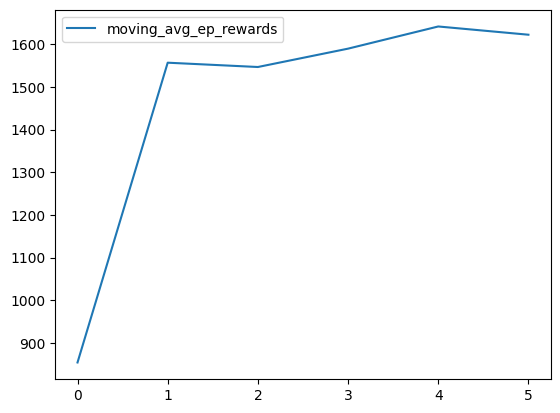

In [22]:
save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 100
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Render the game frame
        env.render()
        
        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

## Conclusion

In this tutorial, we saw how we can use PyTorch to train a game-playing AI. You can use the same methods
to train an AI to play any of the games at the [OpenAI gym](https://gym.openai.com/)_. Hope you enjoyed this tutorial, feel free to reach us at
[our github](https://github.com/yuansongFeng/MadMario/)_!



In [ ]:
import gym
import torch
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from pathlib import Path
from my_mario_model import MarioNet  # Replace 'my_mario_model' with your model module

def load_model(checkpoint_path):
    model = MarioNet(input_dim=(4, 84, 84), output_dim=7)  # Adjust parameters as per your model
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model.eval()
    return model

def play_mario(model, episodes=1):
    env = gym_super_mario_bros.make("SuperMarioBros-v1")
    env = JoypadSpace(env, SIMPLE_MOVEMENT)

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Preprocess the state if necessary
            state = preprocess_state(state)

            # Convert state to tensor and unsqueeze to add batch dimension
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

            # Get action from the model
            with torch.no_grad():
                action_values = model(state)
                action = torch.argmax(action_values, dim=1).item()

            # Step the environment
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

        print(f"Episode {episode + 1} completed with total reward: {total_reward}")

def preprocess_state(state):
    # Implement any necessary preprocessing steps here (e.g., resize, grayscale, etc.)
    return state

if __name__ == "__main__":
    checkpoint_path = Path("checkpoints") / "mario_net_1.chkpt"  # Adjust path accordingly
    model = load_model(checkpoint_path)
    play_mario(model, episodes=5)  # Adjust number of episodes as needed
